# Continuum Subraction
This notebook along with a program called `continuum_sub.py` will demonstrate how continuum subtraction is performed on the NIRCam images of NGC 3324 from JWST.

In [2]:
# use the entire screen width for the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
# imports
import os
import sys
import glob
import numpy as np
#
import matplotlib.pyplot as plt
#
import warnings
warnings.filterwarnings('ignore')
#
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb

# add the code folder to the sys path
sys.path.append('../code')
from reproject_combine import reproject

In [4]:
# Convenience function
def open_fits(fname):
    """ Convenience function for reading in fits files, getting 'SCI' data and
    header information."""
    with fits.open(fname) as hdu:
        data = hdu['SCI'].data
        header = hdu['SCI'].header
    
    return data, header

In [5]:
# make interactive plots
%matplotlib notebook

In [11]:
# setup directory and filenames
directory = '/mnt/d/st_images/Carina_level3/'
cont_fname = glob.glob(directory+'*f444w_i2d.fits')[0]
narrow_fname = glob.glob(directory+'*f444w-f470n*')[0]

print('Files found:')
print(cont_fname)
print(narrow_fname)

Files found:
/mnt/d/st_images/Carina_level3/jw02731-o001_t017_nircam_clear-f444w_i2d.fits
/mnt/d/st_images/Carina_level3/jw02731-o001_t017_nircam_f444w-f470n_i2d.fits


In [7]:
# Get data/header
c_dat, c_header = open_fits(cont_fname)
n_dat, n_header = open_fits(narrow_fname)

In [8]:
# Reproject images (this resizes them also for equal array shapes)
list_files = [cont_fname, narrow_fname]
target_wcs = WCS(c_header)
reprojected = reproject(list_files, target_wcs, c_dat)

In [9]:
# flatten the data arrays for plotting
c_dat_flat = reprojected[0].flatten()
n_dat_flat = reprojected[1].flatten()

### Plotting
Now we will plot array values for the narrowband image and wideband images so that we can start deciding on a scale factor to apply to subtract the continuum from the narrowband images.

<IPython.core.display.Javascript object>


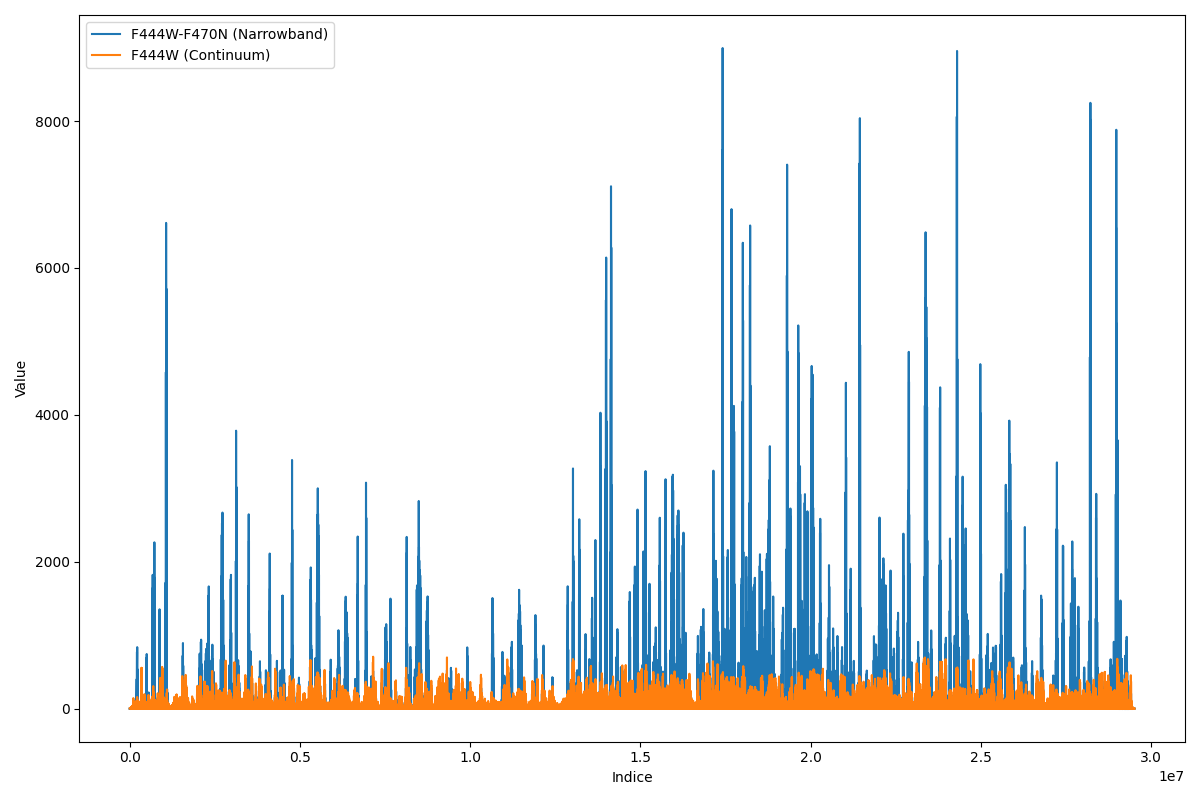

In [12]:
# Plot
plt.figure(figsize=(12,8))
axs = plt.subplot(1, 1, 1)
axs.plot(n_dat_flat, label='F444W-F470N (Narrowband)')
axs.plot(c_dat_flat, label='F444W (Continuum)')
axs.set_xlabel('Indice')
axs.set_ylabel('Value')
plt.legend(loc='best')
plt.tight_layout()